**Keras ANN for Cancer Classification**


Exploring Keras and TensorFlow ANN in Jupyter Notebooks for cancer classification using the Wisconsin Breast Cancer Diagnostic dataset. Resulting accuracy of 94% is less than my [XGBoost attempt in R](https://github.com/m-jmc/m-jmc-XGBoost-Example-WBCD) (95.91), with a bit of tuning we'll see if I cant beat it!

In [ ]:
import pandas
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# load dataset
data = pandas.read_csv("data.csv")

data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# convert M and B to 1 and 0 respectively for fully numeric dataset
cleanup = {"diagnosis":     {"M": 1, "B": 0}}
data.replace(cleanup, inplace=True)


In [4]:
# put columns to delete into a list, then drop the list and create the df data frame
list = ['Unnamed: 32','id',]
df = data.drop(list, axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# create the Y diagnosis dataframe, then drop it from the df dataframe by column id
Y = df.diagnosis
df = df.drop(['diagnosis'], axis=1)

In [6]:
X = df
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


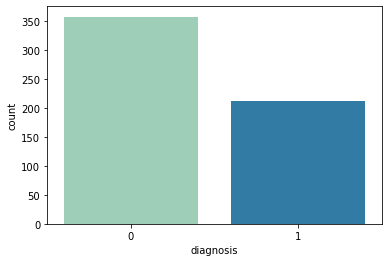

In [100]:
# Use seaborn (sns) to create count plot of benign (0) and malignant (1)
ax = sns.countplot(Y,label="Count",palette="YlGnBu") 

The count of benign (0) and malignant (1) cancer cells represented in the dataset. 

In [8]:
# Review dataset and generate descriptive statistics using describe, excludes NaN
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [9]:
# Create list of column names to use in subsetting mean, worst, and se columns. 
# replaced this approach using X.filter(regex='mean')
#mean = [col for col in X.columns if 'mean' in col]
#worst = [col for col in X.columns if 'worst' in col]
#se = [col for col in X.columns if 'se' in col]
#print(mean)

In [10]:
# using plotly.express px violin for single feature plot
# vio = px.violin(X, y="area_se", x=Y, color=Y, box=True, points="all")
# vio.show()

**Preprocessing**
Scaling / normalizing numeric features. This is of greater importance for linear or distance based algorithms but can increase performance of gradient descent convergence. 

In [11]:
# This creates a scaled array of the dataframe
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

In [12]:
# to convert the scaled array back to the dataframe
X_scale = pandas.DataFrame(x_sc, index=X.index, columns=X.columns)
#print(X_scale)

**Split Violin plot**

I have an affinity for the split violin plot over a simple boxplot. This shows density and distribution in addition to the inner quartiles. Below, only the "mean" features are shown to control document length for brevity. 

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

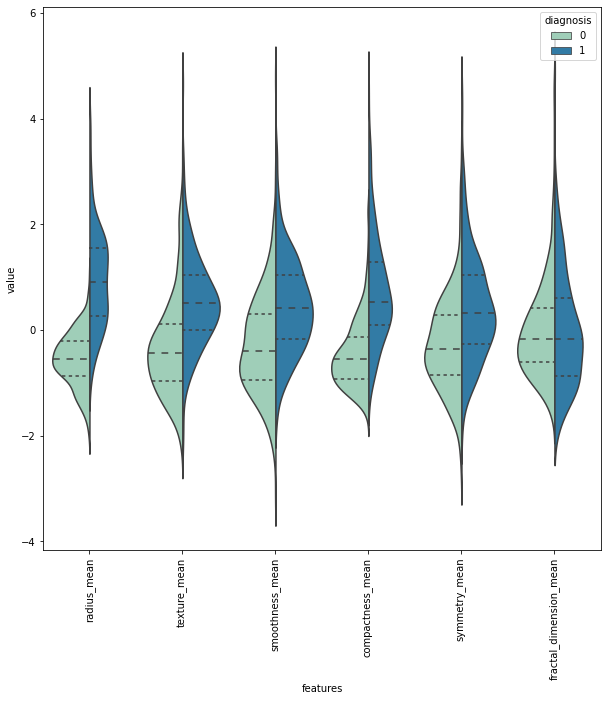

In [95]:
# using pandas to concat Y and the now scaled X, filtering for columns with 'mean' in the name. plotting them as split violin
data = pandas.concat([Y,X_scale.filter(regex='mean')],axis=1)
data = pandas.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart", palette="YlGnBu")
plt.xticks(rotation=90)

In [14]:
#data = pandas.concat([Y,X_scale.filter(regex='worst')],axis=1)
#data = pandas.melt(data,id_vars="diagnosis",
#                    var_name="features",
#                    value_name='value')
#plt.figure(figsize=(10,10))
#sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart", palette="Blues")
#plt.xticks(rotation=90)

In [15]:
#data = pandas.concat([Y,X_scale.filter(regex='se')],axis=1)
#data = pandas.melt(data,id_vars="diagnosis",
#                    var_name="features",
#                    value_name='value')
#plt.figure(figsize=(10,10))
#sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart", palette="Blues")
#plt.xticks(rotation=90)

**Swarm Plot**

Again shortcutting some of the EDA, a swarm plot of the "mean" features.

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

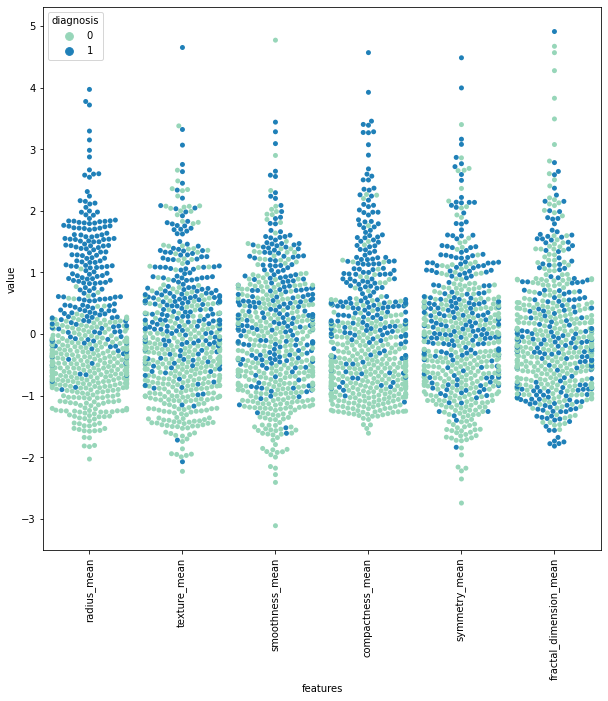

In [94]:
# Swarm plot of the seaborn package shows the distribution a bit easier
data = pandas.concat([Y,X_scale.filter(regex='mean')],axis=1)
data = pandas.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data, palette="YlGnBu")
plt.xticks(rotation=90)

**Corrlation Heatmap**

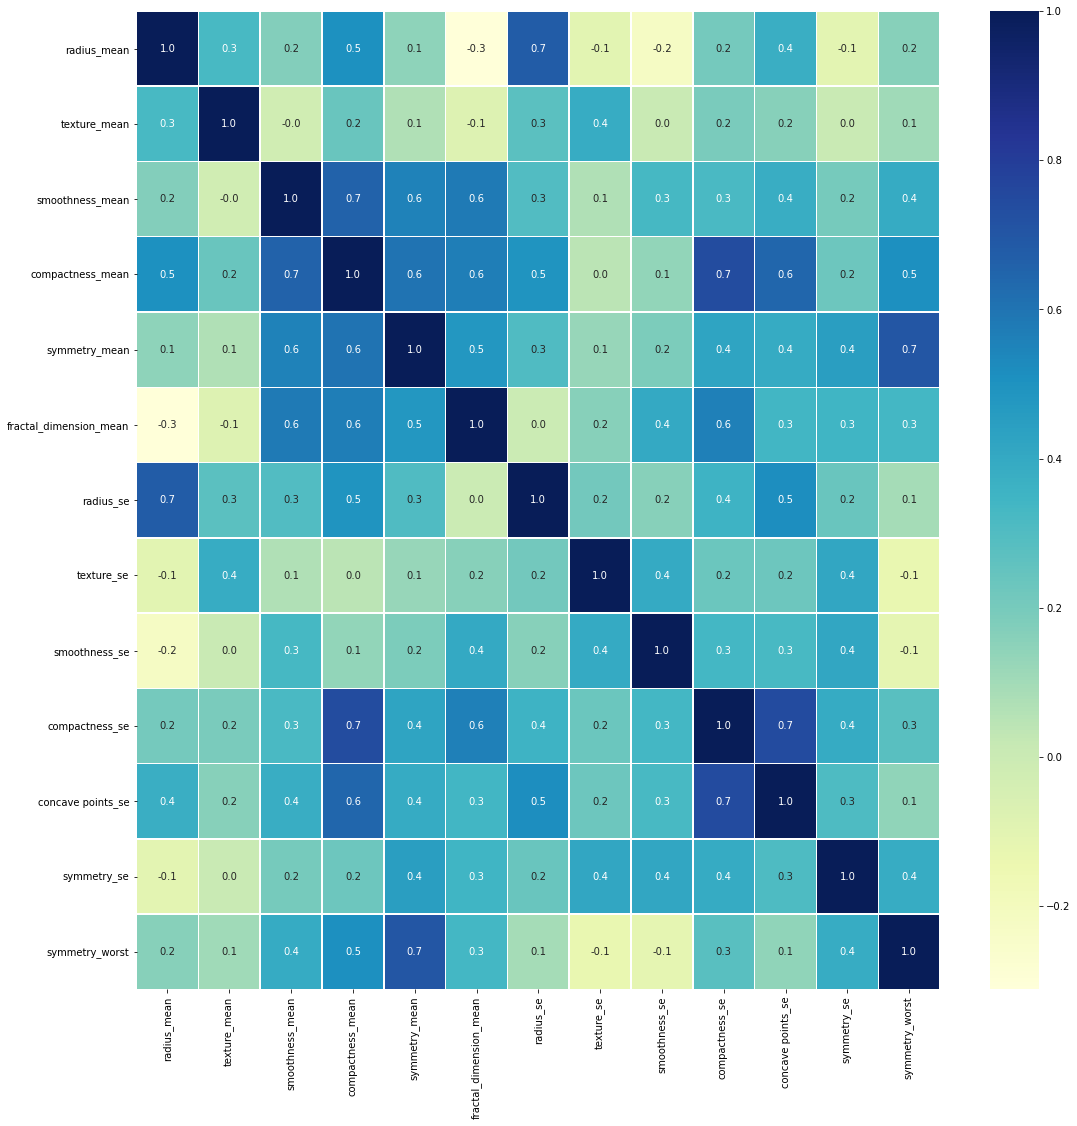

In [93]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X_scale.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="YlGnBu")

Here I'm dropping highly correlated features (Corr > .8). This isn't strictly needed when using ANN. 
However, doing so will increase speed and reduce model complexity (even if I'm using an overly complex model for this task [Meme](https://me.me/i/cs-undergrads-problem-that-can-be-solved-with-linear-regression-e032098d340f4836a2478237f5c73cc0).

In [18]:
# Create correlation matrix
corr_matrix = X_scale.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
# Varaibles to drop
print(to_drop)

['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'concavity_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'fractal_dimension_worst']


In [19]:
# Drop correlated features from dataset
X_scale.drop(to_drop, axis=1, inplace=True)

In [97]:
# Final dataset for modeling 
#print(X_scale)
X_scale.head()

,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concave points_se,symmetry_se,symmetry_worst
0,1.097064,-2.073335,1.568466,3.283515,2.217515,2.255747,2.489734,-0.565265,-0.214002,1.316862,0.660820,1.148757,2.750622
1,1.829821,-0.353632,-0.826962,-0.487072,0.001392,-0.868652,0.499255,-0.876244,-0.605351,-0.692926,0.260162,-0.805450,-0.243890
2,1.579888,0.456187,0.942210,1.052926,0.939685,-0.398008,1.228676,-0.780083,-0.297005,0.814974,1.424827,0.237036,1.152255
3,-0.768909,0.253732,3.283553,3.402909,2.867383,4.910919,0.326373,-0.110409,0.689702,2.744280,1.115007,4.732680,6.046041
4,1.750297,-1.151816,0.280372,0.539340,-0.009560,-0.562450,1.270543,-0.790244,1.483067,-0.048520,1.144205,-0.361092,-0.868353


**Building the Classifier**

To this point, data has been preprocessed by scaling and removal of highly correlated variables. In using ANN, significant features have not been selected, nor remailing variable relationships visualized.


This approach uses additional dropout layers and a standard 70 / 30 training / testing validation split with accuracy metric. 

In [74]:
# Splitting into training / testing sets using randomized 70/30 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size = 0.3, random_state = 0)

In [75]:
# Initialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer, dropout layers removed
classifier.add(Dense(13, input_dim=13, kernel_initializer ='uniform', activation='relu'))
classifier.add(Dropout(rate=0.1))
classifier.add(Dense(6, kernel_initializer ='uniform', activation='relu'))
classifier.add(Dropout(rate=0.1))
classifier.add(Dense(1, kernel_initializer ='uniform', activation='sigmoid'))

In [76]:
# Compiling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
# ANN Classifier summary
print(classifier.summary())

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 13)                182       
_________________________________________________________________
dropout_65 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 6)                 84        
_________________________________________________________________
dropout_66 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 7         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPUs Available:  1


In [78]:
# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size=100, epochs=150, verbose=0)

In [79]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [80]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred,y_test)
tn, fn, fp, tp=confusion_matrix(y_pred,y_test).ravel()
print(cm)

[[101   3]
 [  7  60]]


Given that false negatives, that is, a patient having a malignant breast cancer classified as benign, is likely of creater risk than the opposite well evaluate several different performance metrics:

In [81]:
sens= (tp/(tp+fn)*100) # Detection of true positives (recall)
spec= (tn/(tn+fp)*100) # how exact positive label is assigned
prsn= (tp/(tp+fp)*100) # asigning positive events to the positive class (PPV)
fone= (2*(sens*prsn)/(sens+prsn)) # mean of recall and precision
Acc = ((tp + tn)/(tp + tn + fp + fn)*100)
print("Senstivity:",sens)
print("Specificity:",spec)
print("Precision:",prsn)
print("F1:",fone)
print("Accuracy:",Acc)

Senstivity: 95.23809523809523
Specificity: 93.51851851851852
Precision: 89.55223880597015
F1: 92.30769230769229
Accuracy: 94.15204678362574


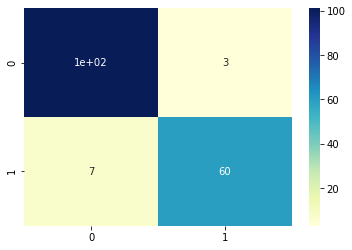

In [96]:
# sns heatmap confusion matrix
sns.heatmap(cm,annot=True, cmap="YlGnBu")
#plt.savefig('h.png')

With this model, we have 7 patients who have had malignant cancer identified as benign.